In [1]:
# -*- coding: utf-8 -*-
import sys
import os
import itertools
import numpy as np
import pandas as pd
import cobra
import matplotlib.pyplot as plt 
plt.rc('axes', axisbelow=True)

print('Python version:', sys.version)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('cobrapy version:', cobra.__version__)

Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.16.4
pandas version: 1.0.3
cobrapy version: 0.15.4


In [2]:
def AddRxn(model, newRxnFile):
    """Function of adding new reactions to the model."""
    n1 = len(model.reactions)
    AllAddRxn = pd.read_csv(newRxnFile, sep=',', index_col='RxnID', skipinitialspace=True)
    n2 = len(AllAddRxn)
    for i in range(n2):
        ID = AllAddRxn.index.values[i]
        addRxn = cobra.Reaction(ID)
        model.add_reactions([addRxn])
        addRxnInf = model.reactions[n1 + i]
        addRxnInf.name = AllAddRxn.loc[ID, 'RxnName']
        addRxnInf.reaction = AllAddRxn.loc[ID, 'RxnFormula']
        addRxnInf.subsystem = AllAddRxn.loc[ID, 'Subsystem']
        addRxnInf.lower_bound = AllAddRxn.loc[ID, 'LowerBound']
        addRxnInf.upper_bound = AllAddRxn.loc[ID, 'UpperBound']
    return model


In [3]:
def KORxn(model, rxns2KO):
    """Function for knocking out reactions."""
    for ID in rxns2KO:
        reaction = model.reactions.get_by_id(ID)
        reaction.knock_out()


In [4]:
def flux2file(model, product, psw, output_dir='tmp'):
    """Function of exporting flux data."""
    n = len(model.reactions)
    modelMatrix = np.empty([n, 9], dtype = object)
    for i in range(len(model.reactions)):
        x = model.reactions[i]
        modelMatrix[i, 0] = i + 1
        modelMatrix[i, 1] = x.id
        modelMatrix[i, 2] = x.name
        modelMatrix[i, 3] = x.reaction
        modelMatrix[i, 4] = x.subsystem
        modelMatrix[i, 5] = x.lower_bound
        modelMatrix[i, 6] = x.upper_bound
        modelMatrix[i, 7] = x.flux
        modelMatrix[i, 8] = abs(x.flux)
        
    df = pd.DataFrame(data = modelMatrix, 
                        columns = ['N', 'RxnID', 'RxnName', 'Reaction', 'SubSystem', 
                        'LowerBound', 'UpperBound', 'Flux-core', 'abs(Flux)'])
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    filepath = os.path.join(output_dir, '{}_{}.xlsx'.format(product, psw))
    df.to_excel(filepath, index=False)
    

In [5]:
def change_objective(model, product='biomass'):
    """change objective function"""
    if product != 'biomass':
        model.objective = f"EX_{product}"

In [6]:
def prodFBA(model, psw, product, subdir= None):
    solution = model.optimize()
    # print("%s: " %product, round(solution.objective_value, 3))
    # export results
    if subdir:
        flux2file(model, product, psw, subdir)
    return round(solution.objective_value, 3)

## Summary of the changes in the model:

#### E. coli full model *i*ML1515 with some changes ('WT' ref):	

* Corrected the transhydrogenase (THD2pp) to one proton translocation;
* Corrected homoserine dehydrogenase to be irreversible, towards homoserine. 
* Knocked out: ATP maintenance (ATPM), pyruvate synthase (POR5), 3pg producing glycerate kinase (GLYCK), 
pyrroloquinoline quinone (PQQ)-glucose dehydrogenase (GLCDpp), 
and the reactions for unrealistic AcCoA production DRPA & PAI2T. 
Knock out of them on top of ATPM does not change the biomass yield on glucose. 
* Knocked out exchange reactions for Fe2+, H2S, Met, and Cys to avoid using Fe or S as electron acceptor.
* Knocked out threonine cleavage routes: L-Thr aldolase (THRA), Thr dehydrogenase (THRD), and glycine C-acetyltransferase (GLYAT).
* Added irreversible hydrogen dehydrogenase (H2DH, H2 + NAD+ -> NADH + H+). 
* Deactivated pyruvate formate lyase (PFL), 2-oxobutanoate formate lyase (OBTFL) under aerobic coditions.

#### In the case of GED pathway, modify phosphogluconate dehydrogenase (GND) to be reversible. 
#### In the case of rPP pathway, add phosphoribulokinase (PRK) and ribulose-bisphosphate carboxylase (RBPC) reactions. 

#### For the cycles:
* CO2 is the only carbon source and with no constraint;
* H2 is the source of electrons and energy and constrained (EX_h2_e lower bound to be -100);
* Modified glyceraldehyde-3-phosphate dehydrogenase (GAPD) to be NADP dependent. 

#### For the shunts:
* Xylose or glucose is the main carbon source and constrained (lower bound to be -10), CO2 is free. 
* To create the shunt variants of GED and rPP, reactions phosphofructokinase (PFK), 
S7P reacting phosphofructokinase (PFK_3), fructose 6-phosphate aldolase (F6PA), 
glucose 6-phosphate dehydrogenase (G6PDH2r), and fructose-bisphosphatase (FBP).

In [7]:
model = cobra.io.load_json_model(r'..\0_ecoli_models\iML1515.json')

model.reactions.THD2pp.add_metabolites({"h_p": 1, "h_c": -1})
model.reactions.HSDy.bounds = (-1000, 0)

In [8]:
KORxn_base = ['POR5', 'GLYCK', 'ATPM', 'GART', 'DRPA', 'PAI2T','GLCDpp']
KORxn(model, KORxn_base)

In [9]:
# Set medium: CO2 as the sole carbon source, no limitation
for rxn in model.boundary:
    if "C" in rxn.check_mass_balance(): # knock out all other carbon-related transporters
        rxn.bounds = (0, 1000)
model.reactions.get_by_id('EX_co2_e').bounds = (-1000, 1000)

# to avoid S as electron acceptor
model.reactions.get_by_id('EX_h2s_e').bounds = (0,0)
model.reactions.get_by_id('EX_met__L_e').bounds = (0,0)
model.reactions.get_by_id('EX_cys__L_e').bounds = (0,0)

model.reactions.get_by_id('EX_fe2_e').bounds = (0,0)  # to avoid Fe as electron acceptor

### first check the cycle

change the glyceraldehyde-3-phosphate dehydrogenase (GAPD) to NADP dependent to be fair.

add hydrogen dehydrogenase to generate elections.

In [10]:
KORxn(model, ['GAPD'])

GAPDn = cobra.Reaction(id="GAPDn", name="glyceraldehyde-3-phosphate dehydrogenase (NADP)", lower_bound=-1000, upper_bound=1000)
model.add_reaction(GAPDn)
GAPDn.add_metabolites({"g3p_c": -1, "nadp_c": -1, "pi_c": -1, "13dpg_c": 1, "h_c": 1, "nadph_c": 1})

model.reactions.get_by_id('EX_h2_e').bounds = (-100, 1000)  # this is the constraint 
H2DH = cobra.Reaction(id="H2DH", name="hydrogen dehydrogenase", lower_bound=0, upper_bound=1000) 
model.add_reaction(H2DH)
H2DH.add_metabolites({"h2_c": -1, "nad_c": -1, "h_c": 1, "nadh_c": 1})


In [11]:
def Rxn4rPP(model):
    # add PRK and RuBisCO reactions
    rb15bp_c = cobra.Metabolite(id='rb15bp_c',
                                formula='C5H8O11P2',
                                name='D-Ribulose 1,5-bisphosphate',
                                compartment='c')
    PRK = cobra.Reaction(id="PRK", name="Phosphoribulokinase", lower_bound=0, upper_bound=1000)
    model.add_reaction(PRK)
    PRK.add_metabolites({"atp_c": -1, "ru5p__D_c": -1, "adp_c": 1, "h_c": 1, rb15bp_c: 1})

    RBPC = cobra.Reaction(id="RBPC", name="Ribulose-bisphosphate carboxylase", lower_bound=0, upper_bound=1000)
    model.add_reaction(RBPC)
    RBPC.add_metabolites({"co2_c": -1, rb15bp_c: -1, "h2o_c": -1, "3pg_c": 2, "h_c": 2})

In [12]:
# validation of rPP (CBB) with biomass
with model:
    # add Rxns to the model
    Rxn4rPP(model)
    KORxn(model,['PFL', 'OBTFL']) # aerobic condition: PFL, OBTFL.
    model.optimize()
    model.summary()
    flux2file(model,'biomass','rPP')

IN FLUXES          OUT FLUXES    OBJECTIVES
-----------------  ------------  ---------------------
h2_e   100         h2o_e  93.3   BIOMASS_Ec_i...  0.46
o2_e    30.1       h_e     4.23
co2_e   18.9
nh4_e    4.97
pi_e     0.443
so4_e    0.116
k_e      0.0897
fe3_e    0.00738
mg2_e    0.00399
ca2_e    0.00239
cl_e     0.00239
cu2_e    0.000326
mn2_e    0.000318
zn2_e    0.000157
ni2_e    0.000148


In [13]:
# validation of GED, with biomass
with model:
    # change GND to be reversible
    model.reactions.GND.bounds = (-1000, 1000)
    KORxn(model,['PFL', 'OBTFL']) # aerobic condition: PFL, OBTFL.
    model.optimize()
    model.summary()
    flux2file(model,'biomass', 'GED')


IN FLUXES          OUT FLUXES    OBJECTIVES
-----------------  ------------  ----------------------
h2_e   100         h2o_e  93.2   BIOMASS_Ec_i...  0.464
o2_e    30         h_e     4.27
co2_e   19
nh4_e    5.01
pi_e     0.447
so4_e    0.117
k_e      0.0906
fe3_e    0.00745
mg2_e    0.00402
ca2_e    0.00241
cl_e     0.00241
cu2_e    0.000329
mn2_e    0.000321
zn2_e    0.000158
ni2_e    0.00015


In [14]:
with model:
    # change GND to be reversible
    model.reactions.GND.bounds = (-1000, 1000)
    KORxn(model,['PFL', 'OBTFL']) # aerobic condition: PFL, OBTFL.
    KORxn(model, ['THRA','THRD','GLYAT'])
    model.optimize()
    model.summary()
    flux2file(model,'biomass_4', 'GED')


IN FLUXES          OUT FLUXES    OBJECTIVES
-----------------  ------------  ----------------------
h2_e   100         h2o_e  93.2   BIOMASS_Ec_i...  0.464
o2_e    30         h_e     4.27
co2_e   19
nh4_e    5.01
pi_e     0.447
so4_e    0.117
k_e      0.0906
fe3_e    0.00745
mg2_e    0.00402
ca2_e    0.00241
cl_e     0.00241
cu2_e    0.000329
mn2_e    0.000321
zn2_e    0.000158
ni2_e    0.00015


In [15]:
with model:
    Rxn4rPP(model)
    KORxn(model,['PFL', 'OBTFL']) # aerobic condition: PFL, OBTFL.   
    KORxn(model, ['THRA','THRD','GLYAT'])
    model.optimize()
    model.summary()
    flux2file(model,'biomass_4','rPP')

IN FLUXES          OUT FLUXES    OBJECTIVES
-----------------  ------------  ----------------------
h2_e   100         h2o_e  93.3   BIOMASS_Ec_i...  0.455
o2_e    30.3       h_e     4.19
co2_e   18.7
nh4_e    4.92
pi_e     0.439
so4_e    0.115
k_e      0.0889
fe3_e    0.00731
mg2_e    0.00395
ca2_e    0.00237
cl_e     0.00237
cu2_e    0.000323
mn2_e    0.000315
zn2_e    0.000155
ni2_e    0.000147


In [16]:
products = ['biomass', 'pyr_e', 'lac__D_e', 'ibtol_e', '23btdl_e',
            'ac_e', 'etoh_e', 'acetone_e', 'but_e', 'buoh_e',
            'hdca_e', 'cit_e', 'itacon_e', 'akg_e', 'succ_e','levu_e']

## Add new reactions for those pathways do not exist natively
* acetone: DOI: 10.1016/j.ymben.2012.08.001 
* butyrate: but_e; DOI: 10.1002/bit.24925
* 1-butanol: buoh_e; DOI: 10.1186/1475-2859-7-36
* Hexadecanoate (n-C16:0): hdca_e; DOI: 10.1038/nature10333
* isobutanol: ibtol_e; DOI: 10.1007/s00253-009-2085-6
* 2,3-butanediol: 23btdl_e; DOI: 10.1021/acssynbio.5b00057
* itaconate: itacon_e; DOI: 10.1007/s10529-017-2500-5
* levulinic acid: levu_e; DOI: 10.1038/nbt.3505

In [17]:
model = AddRxn(model, 'NewRxn4Production.csv')

KORxn(model, ['THRA','THRD','GLYAT'])

unknown metabolite '2mbald_c' created
unknown metabolite 'ibtol_c' created
unknown metabolite 'actn__R_c' created
unknown metabolite '23btdl_c' created
unknown metabolite 'acetone_c' created
unknown metabolite 'buoh_c' created
unknown metabolite 'itacon_c' created
unknown metabolite 'levu_c' created


In [18]:
production_results = pd.DataFrame()

for psw in ['rPP','GED']:
    with model:
        KORxn(model,['PFL', 'OBTFL']) # aerobic condition: PFL, OBTFL.
        if psw == 'rPP':
            Rxn4rPP(model)

        if psw == 'GED':
            model.reactions.GND.bounds = (-1000, 1000)

        for product in products:
            with model:
                if product == 'hdca_e':
                    model.genes.b1093.knock_out() # block the ACP route by KO FabG
                change_objective(model, product)
                production_results.loc[product, psw] = prodFBA(model, psw, product,'output')
                
production_results

,rPP,GED
biomass,0.455,0.464
pyr_e,10.294,10.938
lac__D_e,9.333,9.859
ibtol_e,4.575,4.828
23btdl_e,4.828,5.109
ac_e,12.281,13.208
etoh_e,9.333,9.859
acetone_e,5.932,6.364
but_e,5.303,5.645
buoh_e,4.667,4.930


In [19]:
# yield of rPP as 100%
production_results.to_excel('1_GED cycle results.xlsx')
yield_norm = production_results.div(production_results.rPP, axis=0) * 100
round(yield_norm,1)

,rPP,GED
biomass,100.0,102.0
pyr_e,100.0,106.3
lac__D_e,100.0,105.6
ibtol_e,100.0,105.5
23btdl_e,100.0,105.8
ac_e,100.0,107.5
etoh_e,100.0,105.6
acetone_e,100.0,107.3
but_e,100.0,106.4
buoh_e,100.0,105.6


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


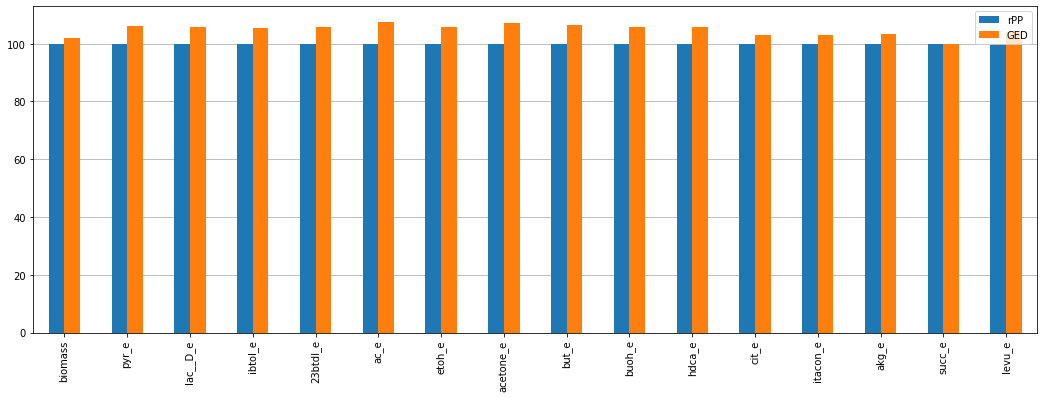

In [20]:
yield_norm.plot.bar(figsize=(18,6))
plt.grid(which='both', axis='y')
plt.savefig('figure_GED cycle.eps', dpi=300, bbox_inches='tight')
plt.show()

### Then, check the linear variant of the pathway for production. 
On glucose or xylose (constraint) as a source of ru5p.
Use a modified WT as a reference. 

In [21]:
uProd = ['ibtol_e','23btdl_e','acetone_e','but_e',
          'buoh_e','itacon_e','levu_e']  # unnatural products
# KO unnatural exchange reactions to aviod as byproducts when fermentating
for product in uProd:
    model.reactions.get_by_id(f'EX_{product}').bounds = (0,0)

# change back GAPD to be NAD dependent
model.reactions.GAPD.bounds = (-1000, 1000)
model.reactions.GAPDn.knock_out()

In [22]:
CSs = ['glc','xyl']
PSWs = ['ref','rPP','GED']
o2 = [-1000, 0]
h2 = [-1000, 0]
columns = pd.MultiIndex.from_product([CSs,PSWs,o2,h2],names=['CS','PSW','O2','H2'])
shunt_prod = pd.DataFrame(columns=columns, index=products[1:], dtype=float)  # biomass is not an interested product
by_prod_ex = pd.DataFrame(columns=columns, index=products[1:])

In [23]:
# for reducing running time
EXrxns = []
for rxn in set(model.boundary).difference([model.reactions.EX_co2_e]):
    if 'C' in rxn.check_mass_balance():
        EXrxns.append(rxn)

In [24]:
def shunt_production(model,psw,cs,o2,h2,product,path):
    if psw == 'rPP':
        KORxn(model,['PFK', 'F6PA', 'G6PDH2r', 'PFK_3','FBP']) # to break the cyclic rPP to a linear shunt
        Rxn4rPP(model)
    elif psw == 'GED':
        KORxn(model,['PFK', 'F6PA', 'G6PDH2r', 'PFK_3','FBP'])
        model.reactions.GND.bounds = (-1000, 1000)
    
    model.reactions.get_by_id(f'EX_{cs}__D_e').lower_bound = -10
    model.reactions.get_by_id('EX_o2_e').lower_bound = o2
    if o2 == -1000:
        KORxn(model,['PFL', 'OBTFL']) # aerobic condition: PFL, OBTFL.
    model.reactions.get_by_id('EX_h2_e').lower_bound = h2

    if product in uProd:
        model.reactions.get_by_id(f'EX_{product}').upper_bound = 1000
    
    change_objective(model, product)

    shunt_prod.loc[product, 
                   (cs,psw,o2,h2)] = prodFBA(model, 
                                             psw, 
                                             '_'.join([cs,product,'O2',str(o2),'H2',str(h2)]), 
                                             path)
    
    for rxn in set(EXrxns).difference([model.reactions.get_by_id(f'EX_{product}')]):
        if rxn.flux > 0.001:
            by_prod_ex.loc[product,(cs,psw,o2,h2)] = True
            break
        

In [25]:
# save = True 
save = False
path = None

for cs, psw, o2_lb, h2_lb, product in itertools.product(CSs,PSWs,o2,h2,products[1:]):  # biomass is not an interested product
    with model:
        if product == 'hdca_e':
            model.genes.b1093.knock_out() # block the ACP route by KO FabG
        if save:
            path = '_'.join([cs,psw])
        shunt_production(model,psw,cs,o2_lb,h2_lb,product,path)


In [26]:
by_prod_ex.fillna(value=False,inplace=True)

def highlight(v):
    """To highlight the cases with by-product secretion"""
    return by_prod_ex.applymap(lambda x: 'background-color: yellow' if x else '')

shunt_prod.style.apply(highlight, axis=None)

In [27]:
shunt_prod.style.apply(highlight, axis=None).to_excel('2_GED shunt results.xlsx')

In [28]:
yield_norm_shunt = pd.concat([shunt_prod.glc.div(shunt_prod.glc.ref,axis=0) * 100,
                              shunt_prod.xyl.div(shunt_prod.xyl.ref,axis=0) * 100],
                              axis=1, keys=CSs, names=['CS'])

yield_norm_shunt.drop(columns='ref',level=3,inplace=True)  # remove the ref column
yield_norm_shunt.round(1)

CS           glc                                                     xyl  \
O2         -1000                        0                          -1000   
H2         -1000          0            -1000          0            -1000   
PSW          rPP    GED    rPP    GED    rPP    GED    rPP    GED    rPP   
pyr_e      125.0  125.0  117.4  119.1  150.0  187.5  150.0  175.0  120.0   
lac__D_e   125.0  125.0   95.3   95.7  100.0  125.0   64.3   80.4  120.0   
ibtol_e    125.0  125.0   95.1   95.4   72.7  113.6   58.6   72.6  120.0   
23btdl_e   125.0  125.0  104.3  105.9  100.0  156.2   90.0  112.5  120.0   
ac_e       125.0  125.0  125.0  125.0  187.5  187.5  187.5  187.5  120.0   
etoh_e     125.0  125.0   95.3   95.7  100.0  125.0   64.3   80.4  120.0   
acetone_e  125.0  125.0  125.0  125.0  187.5  187.5  187.5  187.5  120.0   
but_e      125.0  125.0  119.2  119.2  125.0  125.0  116.7  116.7  120.0   
buoh_e     125.0  125.0   95.3   95.7  100.0  125.0   64.3   80.4  120.0   
hdca_e     125.0  125.0  100.2  100.6   97.0  125.0   69.9   87.4  120.0   
cit_e      125.0  125.0  115.8  120.0   70.0  114.9   70.0  114.8  120.0   
itacon_e   125.0  125.0  122.5  125.0   85.4  137.0   85.4  137.0  120.0   
akg_e      125.0  125.0  125.0  125.0   90.3  153.7   90.3  153.7  120.0   
succ_e     125.0  125.0   93.0   97.0   57.1   72.5   59.9   82.9  120.0   
levu_e     125.0  125.0  112.2  117.3   73.1  118.5   73.1  118.1  120.0   

CS                                                          
O2                               0                          
H2                 0            -1000          0            
PSW          GED    rPP    GED    rPP    GED    rPP    GED  
pyr_e      120.0  118.3  120.0  150.0  180.0  150.0  180.0  
lac__D_e   120.0   96.2   96.6  105.0  120.0   72.9   87.7  
ibtol_e    120.0   96.0   96.4   76.4  109.1   66.2   78.6  
23btdl_e   120.0  105.2  106.9  105.0  150.0  102.0  121.3  
ac_e       120.0  120.0  120.0  180.0  180.0  180.0  180.0  
etoh_e     120.0   96.2   96.6  105.0  120.0   72.9   87.7  
acetone_e  120.0  120.0  120.0  180.0  180.0  180.0  180.0  
but_e      120.0  120.0  120.0  120.0  120.0  120.0  120.0  
buoh_e     120.0   96.2   96.6  105.0  120.0   72.9   87.7  
hdca_e     120.0  101.2  101.6  101.8  120.0   79.2   95.0  
cit_e      120.0  116.7  120.0   74.5  119.1   74.5  119.1  
itacon_e   120.0  120.0  120.0   89.9  143.9   89.9  143.9  
akg_e      120.0  120.0  120.0   88.9  153.2   88.9  153.2  
succ_e     120.0   93.8   98.0   60.0   78.0   64.3   88.4  
levu_e     120.0  113.1  117.9   74.4  119.1   74.4  119.1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

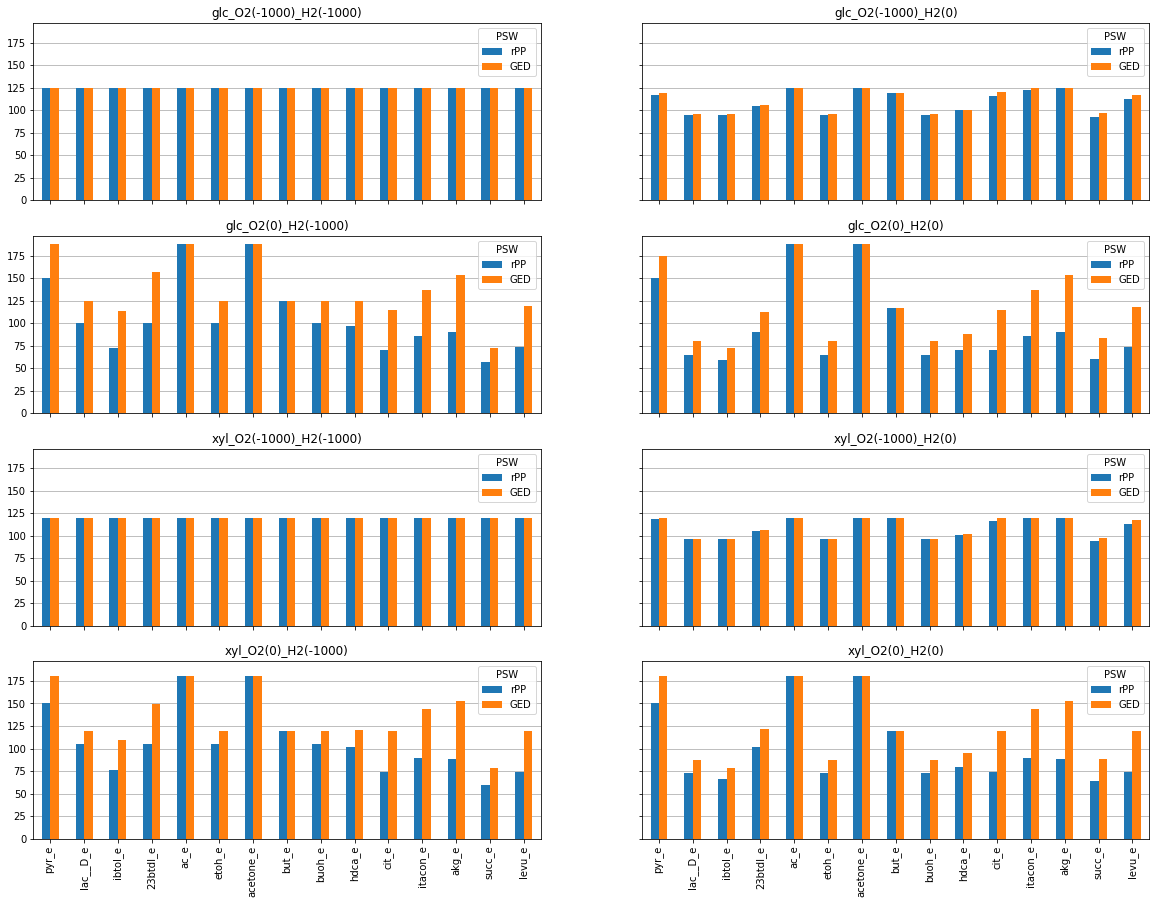

In [30]:
fig, axs = plt.subplots(nrows=4,ncols=2,sharex=True,sharey=True,figsize=(20, 15))

for i, j, n in itertools.product([0,1],  # O2 
                                 [0,1],  # H2
                                 [0,1]): # CS
    yield_norm_shunt.plot.bar(y=(CSs[n],o2[i],h2[j]),
                              title='_'.join([CSs[n],f'O2({o2[i]})',f'H2({h2[j]})']),
                              ax=axs[i+2*n,j])
    axs[i+2*n,j].grid(which='both', axis='y')
    
fig.savefig('figure_GED shunt.eps', dpi=300, bbox_inches='tight')
plt.show()